# Focus on SHC and SC GLASSES functions where we have flat beta

In [1]:
import sys
sys.path.insert(1, '/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/')
import nfmc_jax
import arviz as az
import matplotlib
import getdist
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
import numpy as np
import scipy
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax.scipy.stats import multivariate_normal as mvn
from scipy.stats import multivariate_normal as n_mvn
from jax.scipy.stats import uniform
import chaospy
from nfmc_jax.sinf.RQspline import kde
import torch
from scipy.special import loggamma
import warnings
import os
from matplotlib.gridspec import GridSpec
from scipy.stats import multivariate_normal as mvn
colors =plt.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

seed=1234
np.random.seed(seed)
key = jax.random.PRNGKey(seed)
warnings.filterwarnings('ignore') #ignore overflow warnings



### Misc functions

In [2]:
def t2a(tens): return tens.numpy().astype(np.float64)
def a2t(arr): return torch.from_numpy(arr.astype(np.float32))
def log_flat_one(x,low,high): #set prior to 1 for these pure optimization examples
    n=x.shape[-1]
    return 0

def get_metrics(trace,verbose=True):
    #add maxp point
    maxq=np.max(np.unique([int(s.split('q')[1].split('_')[0]) for s in list(trace['q_models'][0].keys())]))
    maxidx=np.argmax(trace['logp'][0]['q{0}'.format(maxq)])
    s_maxp = trace['q_samples'][0]['q{0}'.format(maxq)][maxidx]
    maxp = trace['logp'][0]['q{0}'.format(maxq)][maxidx]
    print('value of max logp = {0}, at {1}, with {2} levels and {3} total calls'.format(maxp,s_maxp,maxq,len(trace['q_samples'][0]['q{0}'.format(maxq)])))
    return maxp,s_maxp,maxq,len(trace['q_samples'][0]['q{0}'.format(maxq)])

def plot_opt_gd(trace,opt_func,low,high,Ngd=1000,beta_idx=None,random_init=True):
    qmodels=trace['q_models']
    logp=trace['logp']
    samples=trace['q_samples']
    qnums = np.unique([int(s.split('q')[1].split('_')[0]) for s in list(trace['q_models'][0].keys())])
    names = ["x%s"%i for i in range(n)]
    labels =  ["x_%s"%i for i in range(n)]

    #for truth, evaluate on sobol points and apply weights
    if(random_init):
        init = np.random.uniform(low=low,high=high,size=(Ngd,n))
    else:
        init = np.atleast_2d(chaospy.Iid(chaospy.Uniform(lower=low,upper=high),n).sample(Ngd,rule='sobol')).T
    
    truth = np.squeeze(np.array([np.exp(opt_func(init[i])) for i in range(Ngd)])) #obviously this will be slow
    truth_gd = MCSamples(samples=init, weights=truth, names = names, labels = labels, label='truth')

    if(beta_idx is None): beta_idx=qnums.max()
    s_w,s_uw = t2a(qmodels[0]['q{0}_w'.format(beta_idx)].sample(Ngd,device='cpu')[0]),t2a(qmodels[0]['q{0}_uw'.format(beta_idx)].sample(Ngd,device='cpu')[0])
    samples_w = MCSamples(samples=s_w,names = names, labels = labels, label='q_w')
    samples_uw = MCSamples(samples=s_uw,names = names, labels = labels, label='q_uw')

    # Triangle plot
    g = plots.get_subplot_plotter()
    g.triangle_plot([samples_uw,truth_gd,samples_w], filled=True,markers=dict(zip(names,get_metrics(trace)[1]))) #add maxp point
    

    plt.show()

In [3]:
#a place to put the common settings to declutter the below but still be transparent
def run_nfo(log_like,log_prior,
    n, #dim
    bounds=None,
    low=-1.,
    high=1.,
    knots=None,
    knots_trainable=5,
    bw=1.,
    rel_bw=1,
    layers=5,
    ktrunc=jnp.inf,
    t_ess=0.7,
    beta_max=1.5,
    rel_beta=0.5,
    frac_rel_beta_AF = 1,
    alpha_w = (0,0),
    alpha_uw = (0,0),
    latent_sigma=2.4/(2**2),  #FIXME put this in the code as default
    use_latent_beta2=False,
    use_latent_z0=False,
    use_pq_beta_IW1=False, 
    top_verbose=True,
    verbose=False,
    trainable_qw=True,
    sgd_steps=10,
    gamma=0,
    lossfunc=0,
    optimize_directions=False,
    a=1,
    b=1,
    c=1,
    d=1,
    N_temp=None,
    random_init=False,seed=seed,
    n_prior=None,
    retrain_SNF=False,
    rel_min_delta_beta=True,
    min_delta_beta=0.01,
    max_delta_beta=None,
    logp_cut = 0,
    logp_cut_beta = 1e99):
    
    if(N_temp is None): N_temp = 12*n
    if(n_prior is None): n_prior = 10*n
    n0=n_prior
    N=n_prior
    aN=int(2*N*a)
    bN=int(n*b)
    cN=int(n*c)
    dN=int(n*d)
    if(n<6):
        latent_sigma=1
    else:
        latent_sigma*=((n)**(-1/2))
    dist1d = chaospy.Iid(chaospy.Uniform(lower=low,upper=high),n)
    if bounds is None: bounds=np.array([low*np.ones(n),high*np.ones(n)])
    if(random_init):
        np.random.seed(seed)
        init_prior = np.array([np.random.uniform(low=bounds[0,i],high=bounds[1,i],size=(n_prior)) for i in range(n)]).T
    else:
        init_prior=dist1d
        init_prior = np.atleast_2d(dist1d.sample(n_prior+1,rule='sobol')).T[1:] #drop first (0,0) sample because cheating
    trace = nfmc_jax.infer_nfomc(log_like, log_prior, jnp.array(init_prior), 
                             log_prior_args=((jnp.array([low]), jnp.array([high]))), 
                             inference_mode="optimization", 
                              vmap=True, parallel_backend=None, 
                               n0=n0,
                               N=N,
                               t_ess=t_ess,
                               N_AF=aN,
                               expl_top_AF=bN,
                               expl_top_qw=cN,
                               expl_latent=dN,
                               bounds=bounds,
                               beta_max=beta_max,
                               nf_iter=1, 
                               N_temp=N_temp,
                               rel_bw=rel_bw,
                               rel_beta=rel_beta,
                               frac_rel_beta_AF = frac_rel_beta_AF,
                               latent_sigma=latent_sigma,
                               use_latent_beta2=use_latent_beta2,
                               use_latent_z0=use_latent_z0,
                               use_pq_beta_IW1=use_pq_beta_IW1,
                               k_trunc=ktrunc,
                               #sinf parameters
                               frac_validate=0.0,
                               alpha_w=alpha_w,
                               alpha_uw=alpha_uw,
                               NBfirstlayer=True, 
                               verbose=verbose,
                               top_verbose=top_verbose,interp_nbin=knots,iteration=layers,
                               bw_factor_min=bw,bw_factor_max=bw,bw_factor_num=1, #manually force bw factor
                               trainable_qw=trainable_qw,
                               sgd_steps=sgd_steps,
                               gamma=gamma,
                               knots_trainable=knots_trainable,
                               random_seed=seed,
                               train_updates=retrain_SNF,
                               lossfunc=lossfunc,
                               optimize_directions=optimize_directions,
                               rel_min_delta_beta=rel_min_delta_beta,
                               min_delta_beta=min_delta_beta,
                               max_delta_beta=max_delta_beta,
                               logp_cut = logp_cut,
                               logp_cut_beta = logp_cut_beta
                             )
    
    return trace

# GLASSES examples

### Six-Hump Camel

In [6]:
# plotting functions
def plot_maxs(traces=[],labels=[],true_max=1,means=False):
    plt.figure()
    marker_cycler=['s','d','o','.']
    vals =[]
    for j,trace in enumerate(traces):
        maxq=np.max(np.unique([int(s.split('q')[1].split('_')[0]) for s in list(trace['q_models'][0].keys())]))
        for i in range(1,maxq+1):
            label = labels[j] if len(labels)>0 and i==1 else None
            plt.scatter(trace['betas'][0][i]*trace['q_samples'][0]['q_beta_true'],np.max(trace['logp'][0]['q{0}'.format(i)]),
                        c='C{0}'.format(j),label=label,marker=marker_cycler[j%4])
        vals.append(np.max(trace['logp'][0]['q{0}'.format(maxq)]))
    plt.axhline(true_max,label='true maximum',ls='--',c='k')
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'$\max \{\log p\}$')
    plt.legend(prop={"size":10})
    if(means): 
        return np.mean(vals)
    plt.show()
    
def gap(trace,value=None,label="beta_max",opt=-1.03163,fmax=5.7333,first_few=None):
    
    if(value is not None): print(label+" = {0}".format(float(value)))
    get_metrics(trace)
    first = fmax- np.exp(np.max(trace['logp'][0]['q0']))  if(first_few is not None) else fmax- np.exp(np.max(trace['logp'][0]['q0'][:first_few])) 
    best =  fmax-  np.exp(np.max(trace['logp'][0]['q{0}'.format(np.max(np.unique([int(s.split('q')[1].split('_')[0]) for s in list(trace['q_models'][0].keys())])))]))
    gap = (first-best)/(first-opt)
    print("gap = {0}".format( gap ))
    return gap

def plot_IW3(traces,params,param_name='n0'):
    k=0
    for k in range(len(params)):
        ess_dict = traces[k]['total_ess'][0]
        j=0
        cmap = plt.cm.Blues(np.linspace(0.1,1.,len(traces[k]['betas'][0])))
        plt.figure()
        plt.title(param_name+'={0:.2f}'.format(params[k]))
        for i,ess in enumerate(ess_dict):
            if('ESS3' in ess):
                j+=1
                label = 'beta={0:.3f}, ESS3={1}'.format(traces[k]['q_samples'][0]['q_beta_true']*traces[k]['betas'][0][j],ess_dict[ess]) if(j==1 or j ==len(traces[k]['betas'][0])-1) else None
                plt.ylabel(r'$\log IW_{3}$')
                plt.xlabel('samples')
                plt.plot(traces[k]['importance_weights'][0]['q{0}_IW3'.format(j)],
                         marker='o',ls=' ',c=cmap[j],
                         label=label)
        plt.legend(prop={'size':10})
        plt.axvline(len(traces[k]['q_samples'][0]['q0']),ls=':',c='k',label=param_name)
        plt.show()
    return 0

In [7]:
def log_shc(x):
    x1,x2 = x
    f = (4 - 2.1 * x1**2 + x1**4 / 3)*x1**2 + x1*x2 + (-4 + 4*x2**2)*x2**2
    fmax = 5.7333 #for bounds [-2,2] x [-1,1]
    #fmin = -1.03163
    return jnp.log(fmax-f) #check to make sure always pos


## Vary N0


Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
n0 = 5.0
value of max logp = 1.906496524810791, at [-0.02202678  0.7536496 ], with 3 levels and 15 total calls
gap = 0.8180189015080819
n0 = 10.0
value of max logp = 1.80299973487854, at [-0.22676039  0.36078215], with 5 levels and 28 total calls
gap = 0.024173026199802935
n0 = 15.0
value of max logp = 1.9100836515426636, at [ 0.09145641 -0.748926  ], with 7 levels and 41 total calls
gap = 0.9870227973745134
n0 = 20.0
value of max logp = 1.8963086605072021, at [-0.0548892 -0.7538221], with 5 levels and 38 total calls
gap = 0.3531470152732972
n0 = 30.0
value of max logp = 1.9101635217666626, at [ 0.06547642 -0.74265313], with 6 levels and 52 total calls
gap = 0.8471016786961949


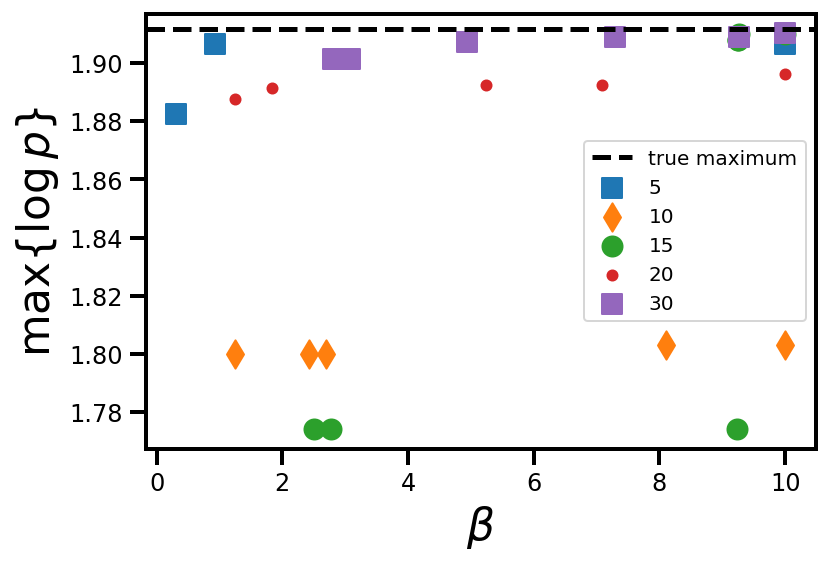

In [11]:
n0s,n0y = [5,10,15,20,30],[]
for n0 in n0s: n0y.append(
                   run_nfo(n=2,n_prior=n0,log_like=log_shc,log_prior=log_flat_one,top_verbose=False,verbose=False,
                   bounds=np.array([[-2,-1],[2,1]]),
                           random_init=True,beta_max=10,a=1,d=0,c=1,b=1,rel_beta=1,t_ess=0.7,lossfunc=2,
                           use_latent_z0=False,
#                    logp_cut=.80,logp_cut_beta=0.8, #latter is in internal beta
                   rel_min_delta_beta=False,
                   min_delta_beta=0.01
                 ))
for i,n0yi in enumerate(n0y):  gap(n0yi,n0s[i],opt=-1.03163,fmax=5.7333,label='n0')
plot_maxs(n0y,labels=n0s,true_max=np.log(5.7333--1.03163 )) #plots

Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
a = 0.5
value of max logp = 1.8797038793563843, at [-0.03915048 -0.55114937], with 5 levels and 37 total calls
a = 1.0
value of max logp = 1.7742717266082764, at [ 0.0039805  -0.20559484], with 4 levels and 32 total calls
a = 2.0
value of max logp = 1.8839315176010132, at [-0.1273309 -0.7034458], with 4 levels and 32 total calls
a = 10.0
value of max logp = 1.7969924211502075, at [ 0.16645503 -0.3138339 ], with 4 levels and 32 total calls
a = 100.0
value of max logp = 1.7896814346313477, at [ 0.3810122 -0.4398296], with 5 levels and 37 total calls


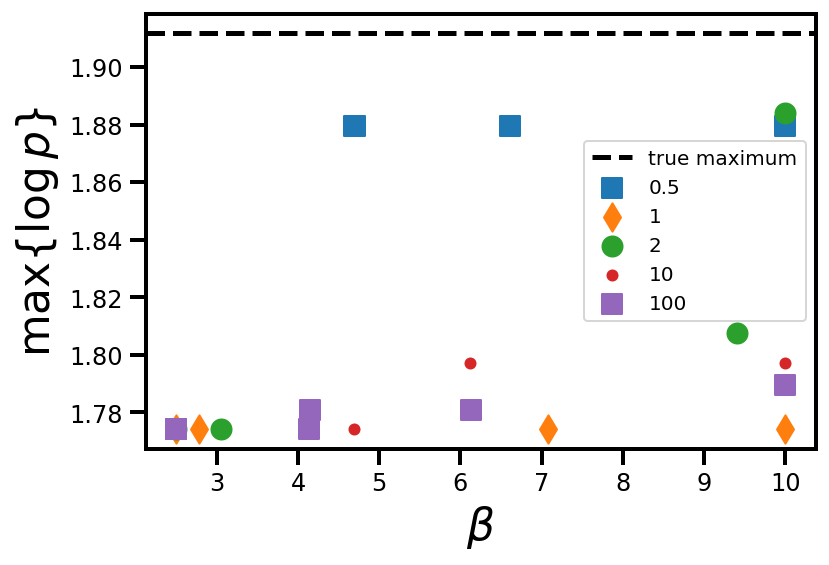

In [17]:
# Vary number of aquisition points - WITHOUT max delta beta
ams,amy = [1/2,1,2,10,100],[]
for am in ams: amy.append(
                   run_nfo(n_prior=15,n=2,log_like=log_shc,log_prior=log_flat_one,top_verbose=False,verbose=False,
                   bounds=np.array([[-2,-1],[2,1]]),random_init=True,beta_max=10,a=am,d=1/2,c=1,b=1,rel_beta=1,t_ess=0.7,lossfunc=2,
                   rel_min_delta_beta=False,min_delta_beta=0.01,
                   use_latent_z0=True,
                 ))
for i,amyi in enumerate(amy):  #info about the run
    print("a = {0}".format(float(ams[i])))
    get_metrics(amyi)
plot_maxs(amy,labels=ams,true_max=np.log(5.7333--1.03163)) #plots


Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
a = 0.5
value of max logp = 1.8884347677230835, at [-0.05894232 -0.60263395], with 6 levels and 47 total calls
a = 1.0
value of max logp = 1.889243483543396, at [ 0.16800737 -0.5811409 ], with 7 levels and 53 total calls
a = 2.0
value of max logp = 1.9116382598876953, at [ 0.08079863 -0.70463824], with 7 levels and 53 total calls
a = 10.0
value of max logp = 1.8467803001403809, at [ 0.33974147 -0.86727214], with 6 levels and 47 total calls
a = 100.0
value of max logp = 1.9109529256820679, at [-0.06771672  0.73174226], with 9 levels and 65 total calls


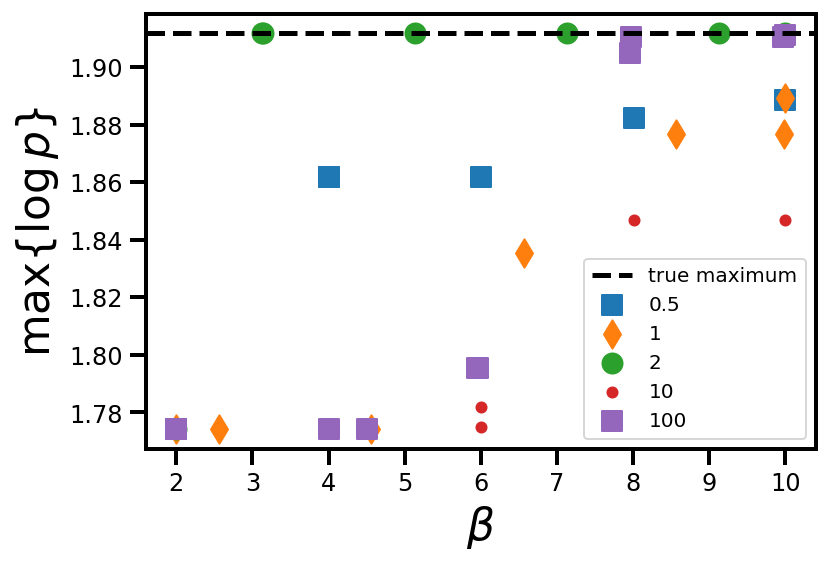

In [16]:
# Vary number of aquisition points WITH max_delta_beta
ams,amy = [1/2,1,2,10,100],[]
for am in ams: amy.append(
                   run_nfo(n_prior=15,n=2,log_like=log_shc,log_prior=log_flat_one,top_verbose=False,verbose=False,
                   bounds=np.array([[-2,-1],[2,1]]),random_init=True,beta_max=10,a=am,d=1,c=1,b=1,rel_beta=1,t_ess=0.7,lossfunc=2,
                   rel_min_delta_beta=False,min_delta_beta=0.01,
                   use_latent_z0=False,max_delta_beta=0.2
                 ))
for i,amyi in enumerate(amy):  #info about the run
    print("a = {0}".format(float(ams[i])))
    get_metrics(amyi)
plot_maxs(amy,labels=ams,true_max=np.log(5.7333--1.03163)) #plots


## Using latent $z=0$

Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
value of max logp = 1.9078888893127441, at [ 0.03270388 -0.6672555 ], with 6 levels and 32 total calls
value of max logp = 1.7742717266082764, at [ 0.0039805  -0.20559484], with 5 levels and 29 total calls


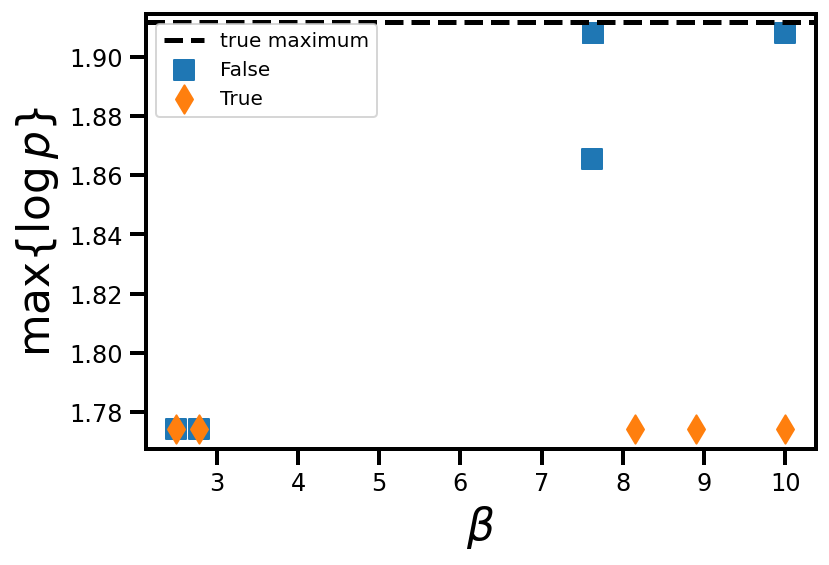

In [18]:
# One top qw sample per iteration vs one latent z=0 sample per iteration (with b=1) WITHOUT max_delta beta
lzy=[]
lzy.append(
                   run_nfo(n_prior=15,n=2,log_like=log_shc,log_prior=log_flat_one,top_verbose=False,verbose=False,
                   bounds=np.array([[-2,-1],[2,1]]),random_init=True,beta_max=10,a=1,d=0,c=1/2,b=1,rel_beta=1,t_ess=0.7,lossfunc=2,
                   rel_min_delta_beta=False,min_delta_beta=0.01,
                   use_latent_z0=False
                 ))
lzy.append(
                   run_nfo(n_prior=15,n=2,log_like=log_shc,log_prior=log_flat_one,top_verbose=False,verbose=False,
                   bounds=np.array([[-2,-1],[2,1]]),random_init=True,beta_max=10,a=1,d=1/2,c=0,b=1,rel_beta=1,t_ess=0.7,lossfunc=2,
                   rel_min_delta_beta=False,min_delta_beta=0.01,
                   use_latent_z0=True
                 ))
for i,lzyi in enumerate(lzy):  #info about the run
    get_metrics(lzyi)
plot_maxs(lzy,labels=['False','True'],true_max=np.log(5.7333--1.03163)) #plots


Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
value of max logp = 1.9114938974380493, at [ 0.07055569 -0.7175188 ], with 9 levels and 41 total calls
value of max logp = 1.8064697980880737, at [ 0.13375115 -0.32735795], with 6 levels and 32 total calls


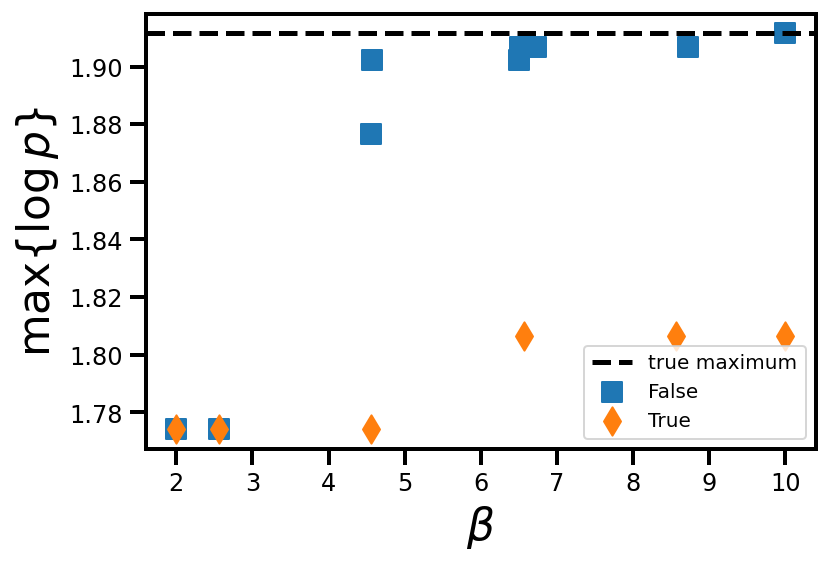

In [19]:
# One top qw sample per iteration vs one latent z=0 sample per iteration (with b=1) WITH max_delta beta
lzy=[]
lzy.append(
                   run_nfo(n_prior=15,n=2,log_like=log_shc,log_prior=log_flat_one,top_verbose=False,verbose=False,
                   bounds=np.array([[-2,-1],[2,1]]),random_init=True,beta_max=10,a=1,d=0,c=1/2,b=1,rel_beta=1,t_ess=0.7,lossfunc=2,
                   rel_min_delta_beta=False,min_delta_beta=0.01,
                   max_delta_beta=0.2,
                   use_latent_z0=False
                 ))
lzy.append(
                   run_nfo(n_prior=15,n=2,log_like=log_shc,log_prior=log_flat_one,top_verbose=False,verbose=False,
                   bounds=np.array([[-2,-1],[2,1]]),random_init=True,beta_max=10,a=1,d=1/2,c=0,b=1,rel_beta=1,t_ess=0.7,lossfunc=2,
                   rel_min_delta_beta=False,min_delta_beta=0.01,
                   max_delta_beta=0.2,
                   use_latent_z0=True
                 ))
for i,lzyi in enumerate(lzy):  #info about the run
    get_metrics(lzyi)
plot_maxs(lzy,labels=['False','True'],true_max=np.log(5.7333--1.03163)) #plots


## Varying fixed max $\Delta \beta$

Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
max delta beta = 100.0
value of max logp = 1.9078888893127441, at [ 0.03270388 -0.6672555 ], with 6 levels and 32 total calls
max delta beta = 0.1
value of max logp = 1.8980789184570312, at [ 0.03170109 -0.6023146 ], with 11 levels and 47 total calls
max delta beta = 0.2
value of max logp = 1.9114938974380493, at [ 0.07055569 -0.7175188 ], with 9 levels and 41 total calls
max delta beta = 0.3
value of max logp = 1.9078888893127441, at [ 0.03270388 -0.6672555 ], with 7 levels and 35 total calls
max delta beta = 0.5
value of max logp = 1.9078888893127441, at [ 0.03270388 -0.6672555 ], with 6 levels and 32 total calls
beta_max = 100.0
value of max logp = 1.9078888893127441, at [ 0.03270388 -0.6672555 ], with 6 levels and 32 total cal

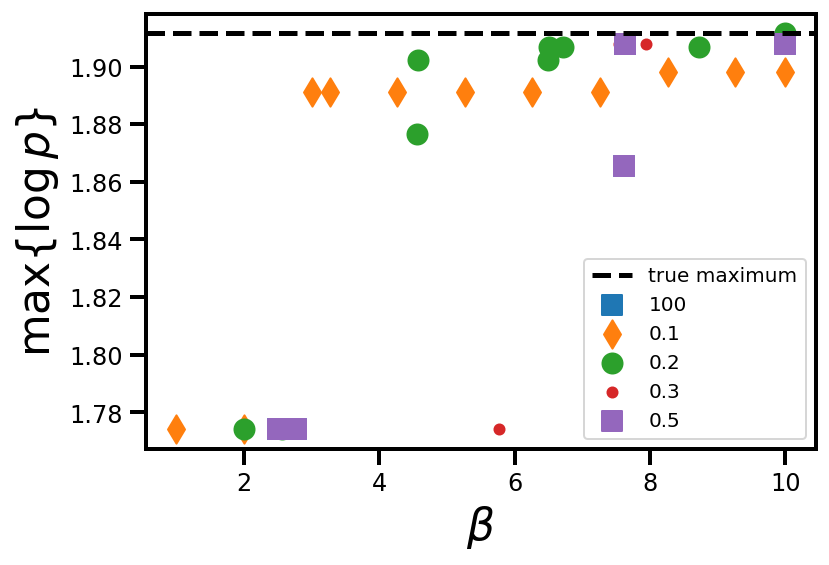

In [20]:
# 
dbms,dbmy = [100,0.1,0.2,0.3,0.5],[]
for dbm in dbms: dbmy.append(
                   run_nfo(n_prior=15,n=2,log_like=log_shc,log_prior=log_flat_one,top_verbose=False,verbose=False,
                   bounds=np.array([[-2,-1],[2,1]]),random_init=True,beta_max=10,a=1,d=0,c=1/2,b=1,rel_beta=1,t_ess=0.7,lossfunc=2,
                   rel_min_delta_beta=False,min_delta_beta=0.01,
                   max_delta_beta = dbm,
                   use_latent_z0=False,
                 ))
for i,dbmyi in enumerate(dbmy):  #info about the run
    print("max delta beta = {0}".format(float(dbms[i])))
    get_metrics(dbmyi)

for i,dbmyi in enumerate(dbmy):  gap(dbmyi,dbms[i],opt=-1.03163,fmax=5.7333)
plot_maxs(dbmy,labels=dbms,true_max=np.log(5.7333--1.03163)) #plots


## Vary $\beta_{\rm{max}}$ with log steps
15 initial points, 1 top qw and 1 AF per iteration

Inference mode is optimization. Maximum beta is: 10
value of max logp = 1.909502625465393, at [ 0.03987622 -0.68310475], with 8 levels and 30 total calls
gap = 0.982508745237283
0.46051701859880917


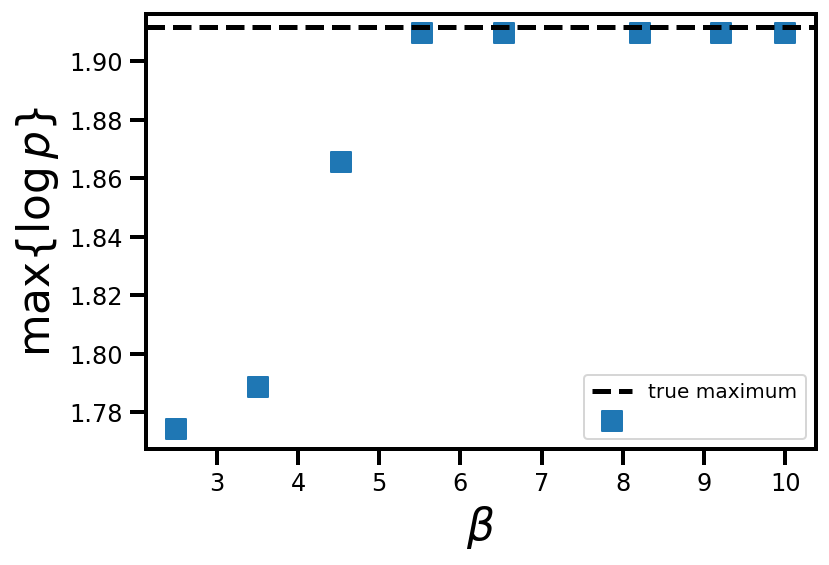

In [27]:
N_levels = 10
beta_max = 10
delta_beta_min = 0.01*beta_max
dbm = np.log(beta_max/delta_beta_min)/N_levels
dbmy = run_nfo(n_prior=15,n=2,log_like=log_shc,log_prior=log_flat_one,top_verbose=False,verbose=False,
                   bounds=np.array([[-2,-1],[2,1]]),random_init=True,beta_max=beta_max,a=1,d=0,c=1/2,b=1/2,rel_beta=1,t_ess=0.7,lossfunc=2,
                   rel_min_delta_beta=True,min_delta_beta=delta_beta_min,
                   max_delta_beta = dbm,
                   use_latent_z0=False,
#                seed=seed+2
                 )

gap(dbmy,opt=-1.03163,fmax=5.7333)
print(dbm)
plot_maxs([dbmy],labels=[' '],true_max=np.log(5.7333--1.03163)) #plots


## Averaging the results (5 times)

In [ ]:
#just using b=1 vs 1/2 makes a big help on avg for n0=15

Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
seed = 0.0
value of max logp = 1.9114938974380493, at [ 0.07055569 -0.7175188 ], with 9 levels and 41 total calls
seed = 1.0
value of max logp = 1.907741665840149, at [ 0.17109084 -0.7018187 ], with 6 levels and 32 total calls
seed = 2.0
value of max logp = 1.9026938676834106, at [-0.05236745  0.62216234], with 7 levels and 35 total calls
seed = 3.0
value of max logp = 1.902583122253418, at [-0.1324557  0.6287204], with 9 levels and 41 total calls
seed = 4.0
value of max logp = 1.9078534841537476, at [ 0.13487768 -0.76126224], with 6 levels and 32 total calls
seed = 0.0
value of max logp = 1.9114938974380493, at [ 0.07055569 -0.7175188 ], with 9 levels and 41 total calls
gap = 0.9979912965380143
seed = 1.0
value of max logp = 1.90

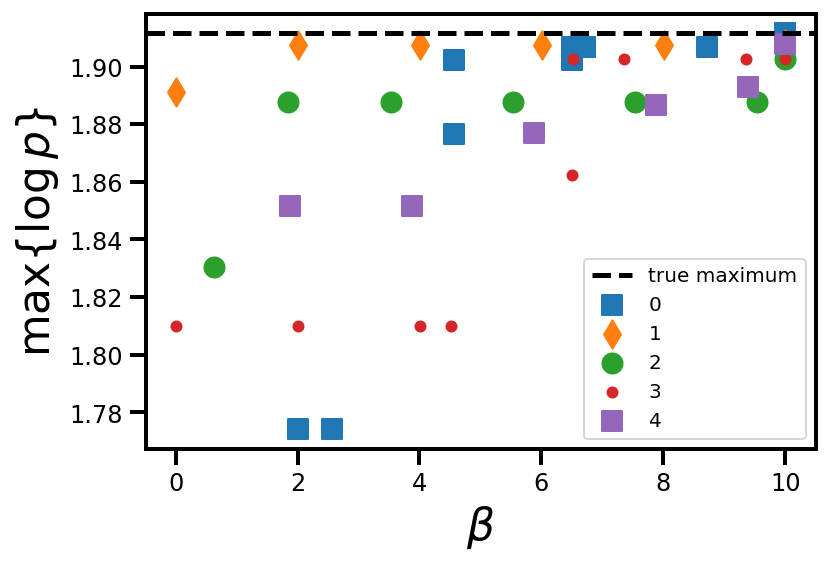

In [28]:
beta_max = 10
Nseeds=5
seedy,seeds=[],[0,1,2,3,4]
for i in range(Nseeds): seedy.append(run_nfo(n_prior=15,n=2,log_like=log_shc,log_prior=log_flat_one,top_verbose=False,verbose=False,
                   bounds=np.array([[-2,-1],[2,1]]),random_init=True,beta_max=beta_max,a=1,d=0,c=1/2,b=1,rel_beta=1,t_ess=0.7,lossfunc=2,
                   rel_min_delta_beta=False,min_delta_beta=0.01,
                   use_latent_z0=False,
                   max_delta_beta=0.2,
                   seed = seed+i
                 ))

for i,seedi in enumerate(seedy):  #info about the run
    print("seed = {0}".format(float(seeds[i])))
    get_metrics(seedi)
gaps=[]
for i,seedi in enumerate(seedy):  gaps.append(gap(seedi,seeds[i],opt=-1.03163,fmax=5.7333,label='seed'))
mean_maxp = plot_maxs(seedy,labels=seeds,true_max=np.log(5.7333--1.03163),means=True) #plots
print("Mean max logp = ",mean_maxp)
print("Mean gap = ", np.mean(gaps))


What is happening here? Run is the same as aboveexcept n0=20 instead of 15? Ess bad match ot max delta beta?
why getting flat regions now? too low ess? try 0.9 - this helps ...a clue maybe...

Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
seed = 0.0
value of max logp = 1.8985950946807861, at [-0.05557585 -0.7289719 ], with 7 levels and 40 total calls
seed = 1.0
value of max logp = 1.8831675052642822, at [ 0.21660256 -0.58319736], with 9 levels and 46 total calls
seed = 2.0
value of max logp = 1.8776134252548218, at [-0.17567706  0.5424882 ], with 6 levels and 37 total calls
seed = 3.0
value of max logp = 1.8784055709838867, at [-0.17558572  0.5451029 ], with 9 levels and 46 total calls
seed = 4.0
value of max logp = 1.8880159854888916, at [-0.23016238  0.6127567 ], with 8 levels and 43 total calls
seed = 0.0
value of max logp = 1.8985950946807861, at [-0.05557585 -0.7289719 ], with 7 levels and 40 total calls
gap = 0.44828353290570766
seed = 1.0
value of max logp =

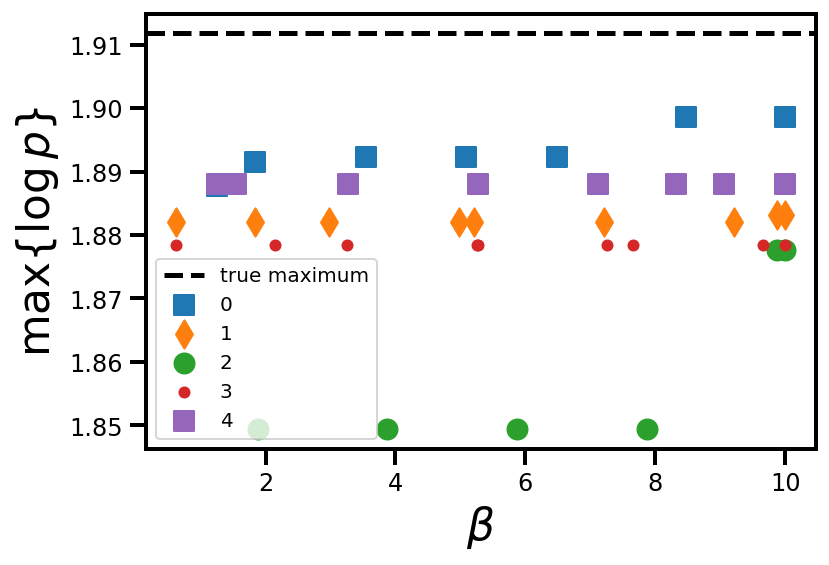

In [29]:
beta_max = 10
Nseeds=5
seedy,seeds=[],[0,1,2,3,4]
for i in range(Nseeds): seedy.append(run_nfo(n_prior=20,n=2,log_like=log_shc,log_prior=log_flat_one,top_verbose=False,verbose=False,
                   bounds=np.array([[-2,-1],[2,1]]),random_init=True,beta_max=beta_max,a=1,d=0,c=1/2,b=1,rel_beta=1,t_ess=0.7,lossfunc=2,
                   rel_min_delta_beta=False,min_delta_beta=0.01,
                   use_latent_z0=False,
                   max_delta_beta=0.2,
                   seed = seed+i
                 ))

for i,seedi in enumerate(seedy):  #info about the run
    print("seed = {0}".format(float(seeds[i])))
    get_metrics(seedi)
gaps=[]
for i,seedi in enumerate(seedy):  gaps.append(gap(seedi,seeds[i],opt=-1.03163,fmax=5.7333,label='seed'))
mean_maxp = plot_maxs(seedy,labels=seeds,true_max=np.log(5.7333--1.03163),means=True) #plots
print("Mean max logp = ",mean_maxp)
print("Mean gap = ", np.mean(gaps))


## Plotting all the beta iterations for one example where things flatten out in maxlogp
This is the case of n0=15 from the first plot in this notebook - things are very flat and then all of a sudden jump to the near the max


In [30]:
def sample_qmodel_1d(qmodel,N,Z=1,dim=0):
    samples,qvalues = qmodel.sample(N,device='cpu')
    #sample n samples
    samples = samples[:,dim]
    #use the sinf kde implementation - should use Scott's rule with no bwfactor
    kdeq = kde(samples)
    def fkde(x):
        return t2a(kdeq(a2t(x)))*Z
    return fkde,samples

def sample_truth_1d(truth_func,truth_domain,N,xx,dim=0):
    samples = sample_opt_function(truth_func,truth_domain,100,5000,seed=seed)
    samples = samples[:,dim]
    kdeq = kde(a2t(samples))
    def fkde(x):
        return t2a(kdeq(a2t(x)))
    return fkde,samples


def sample_truth(truth_func,truth_domain,N,xx,nbins=100):
    samples = sample_opt_function(truth_func,truth_domain,100,5000,seed=seed)
    #use the sinf kde implementation - should use Scott's rule with no bwfactor
#     mask = np.all(samples>bounds[0],axis=-1) & np.all(samples<bounds[1],axis=-1)
#     samples = samples[mask]
    bounds = np.array(truth_domain).T
    k = scipy.stats.kde.gaussian_kde(samples.T,bw_method='scott')
    x1, x2, zi =  prepare_2d_mesh(xx,k,low_high=bounds,nbins=nbins)
    return x1,x2,zi,samples #fkde,samples

def sample_qmodel(qmodel,N,Z,xx,dim=None,verbose=False,bounds=([-1,-1],[1,1]),nbins=100):
    #Input: qmodel, callable. N, number of samples, Z evidence/norm, dim the dimension you want the kde along.
    #If dim=None, use a kde of size dim
    #output: gaussian kde function
    samples,qvalues = qmodel.sample(N,device='cpu')
    samples=t2a(samples)
    mask = np.all(samples>bounds[0],axis=-1) & np.all(samples<bounds[1],axis=-1)
    samples = samples[mask]
    k = scipy.stats.kde.gaussian_kde(samples.T,bw_method='scott')
    x1, x2, zi =  prepare_2d_mesh(xx,k,low_high=bounds,nbins=nbins)
    return x1,x2,zi,samples #fkde,samples

def prepare_2d_mesh(x12,k,low_high=None,nbins=100):
    if (low_high is None): low_high = ([np.min(x12[:,0],axis=0),np.min(x12[:,0],axis=0)],
                                           [np.max(x12[:,1],axis=0),np.max(x12[:,1],axis=0)])
    x1, x2 = np.mgrid[low_high[0][0]:low_high[1][0]:nbins*1j, low_high[0][1]:low_high[1][1]:nbins*1j]
    zi = k(np.vstack([x1.flatten(), x2.flatten()])).reshape(x1.shape)
    return x1,x2,zi

def single_beta_2d_plot(trace,
#                         truth_func,truth_domain,
                        opts,
                       # data,fdata,gdata,
                        beta_idx=1,savename=None,ncont=2,nbins=300,n_1d=100,
                        beta_max=1,
                        Nsamples_1d=1000,
                        low1=0,high1=1,low2=0,high2=1,
                        num_top=3,grad_fac=0.5,
                        arrow_size=.045,arrow_length=3,use_arrows=False,latent_sigma=False,
                        dN=False,cN=False,
                        n0=20,bN=1,min_beta2=2
                        
                       ):
    
    keys=list(trace['q_samples'][0].keys())

    nxx = 10
    xx = np.mgrid[low1:high1:nxx*1j,low2:high2:nxx*1j].reshape(2,-1).T
    logp = trace['logp'][0]
    train_logq = trace['train_logq'][0]
    logZ = trace['logZ'][0]
    IWs = trace['importance_weights'][0]
    samples = trace['q_samples'][0]
    qmodels = trace['q_models'][0]
    betas=np.array(trace['betas'][0][1:])
    if(savename is None): savename='v1_test_beta{0:.7f}'.format(betas[beta_idx-1]*beta_max)
    
    #setup
    fig = plt.figure()
    gs = GridSpec(5,5)
    ax_joint = fig.add_subplot(gs[2:5,0:3])
    ax_marg_x = fig.add_subplot(gs[1,0:3])
    ax_marg_y = fig.add_subplot(gs[2:5,3])
    ax_af_x = fig.add_subplot(gs[0,0:3])
    ax_af_y = fig.add_subplot(gs[2:5,4])
    x1_1d = np.linspace(low1,high1,n_1d)
    x2_1d = np.linspace(low2,high2,n_1d)
    cont_color_idx=-2

    # 2D plot
    conts = []
    uw2 = ax_joint.contour(*sample_qmodel(qmodel=qmodels['q{0}_uw'.format(beta_idx)],N=Nsamples_1d,
                                                 Z=np.exp(logZ['q{0}_pq'.format(beta_idx)]),xx=xx,bounds=([-2,-1],[2,1]))[:3],cmap='Blues',
                                  linestyles='--',zorder=-1)
    conts.append(uw2)
    w2=ax_joint.contour(*sample_qmodel(qmodels['q{0}_w'.format(beta_idx)],Nsamples_1d,
                                      np.exp(logZ['q{0}_pq'.format(beta_idx)]),xx=xx,bounds=([-2,-1],[2,1]))[:3],cmap='Reds',zorder=1)
    conts.append(w2)
#     truth_samples_2d = sample_truth(truth_func,truth_domain,Nsamples_1d,xx)[:2]
#     truth_2d = truth_func(truth_samples_2d)
#     conts.append(ax_joint.contour(*truth_samples_2d, truth_2d,#just x pts, hack
#                 cmap='Greys_r',zorder=0))
    labels = ['Z_pq q_uw','Z_pq q_w']# ,'truth']
    idxs = [cont_color_idx,cont_color_idx]#, 0]
    for i in range(len(labels)): conts[i].collections[idxs[i]].set_label(labels[i])
    
    
    # prior points
    ax_joint.plot(*samples['q0'].T,#np.exp(logp['q0']),
                  ls=' ',marker='s',c='k',label='prior samples',zorder=-1,alpha=0.3)
    ax_joint.plot(samples['q{0}_w_samples'.format(beta_idx)][:,0],
                      samples['q{0}_w_samples'.format(beta_idx)][:,1],
                      ls=' ',marker='.',c='g',label='proposals (w)',alpha=0.5)
    #opt
    for i in range(2): 
        label = 'opt' if(i==0) else None
        ax_joint.scatter(*opts[i],marker='*',color='r',label=label,zorder=6)
    
    # new points
    if(latent_sigma and beta_idx>=min_beta2):
            #top from usual process
            ax_joint.plot(samples['non_latent_q{0}'.format(beta_idx)][:,0],samples['non_latent_q{0}'.format(beta_idx)][:,1],
                          ls=' ',marker='d',c='indigo',label='AF point',zorder=5)

            #draw from latent space
            print(samples['latent_q{0}'.format(beta_idx)])
            if(dN and cN):
                ax_joint.plot(samples['latent_q{0}'.format(beta_idx)][:dN,0],samples['latent_q{0}'.format(beta_idx)][:dN,1],
                              ls=' ',marker='D',c='sienna',label='latent point',zorder=5)
                ax_joint.plot(samples['latent_q{0}'.format(beta_idx)][dN:,0],samples['latent_q{0}'.format(beta_idx)][dN:,1],
                              ls=' ',marker='D',c='gold',label='top qw',zorder=5)
            elif(dN):
                ax_joint.plot(samples['latent_q{0}'.format(beta_idx)][:,0],samples['latent_q{0}'.format(beta_idx)][:,1],
                              ls=' ',marker='D',c='sienna',label='latent point',zorder=5)
            elif(cN):
                ax_joint.plot(samples['latent_q{0}'.format(beta_idx)][:,0],samples['latent_q{0}'.format(beta_idx)][:,1],
                              ls=' ',marker='D',c='gold',label='top qw',zorder=5)
            else:
                ax_joint.plot(samples['latent_q{0}'.format(beta_idx)][:,0],samples['latent_q{0}'.format(beta_idx)][:,1],
                              ls=' ',marker='D',c='purple',label='latent points',zorder=5)

            ax_joint.plot(samples['q{0}'.format(beta_idx)][n0:n0+1,0],
                          samples['q{0}'.format(beta_idx)][n0:n0+1,1],
                          ls=' ',marker='.',c=colors[1],label='old point(s)',zorder=None)
            ax_joint.plot(samples['q{0}'.format(beta_idx)][n0:,0],
                          samples['q{0}'.format(beta_idx)][n0:,1],
                          ls=' ',marker='.',c=colors[1],label=None,zorder=None)

    else:
        for j in range(1,beta_idx+1):
            if(j==beta_idx):
                color_idx = 3
                label='new point'
                zorder=5
            elif(j==beta_idx-1):
                color_idx = 1
                label='old point(s)'
                zorder=None
            else:
                color_idx = 1
                label=None
                zorder=None

            #plot 
            ax_joint.plot(samples['q{0}'.format(j)][n0+int(bN*j)-1,0],
                          samples['q{0}'.format(j)][n0+int(bN*j)-1,1],
                          ls=' ',marker='.',c=colors[color_idx],label=label,zorder=zorder)
        
    # top p points with gradient
    if(num_top<=3):
        rank_colors = ['orangered','forestgreen','royalblue']
        labels_top = ['1st p', '2nd p', '3rd p']
    else:
        cmap = plt.get_cmap('magma_r') #first one is most yellow, last one is most red
        rank_colors = np.array([cmap(k) for k in np.linspace(0, 1, num_top)])
        labels_top = ['p{0}' for k in range(num_top) ]
        
    post_rank = np.argsort(logp['q{0}'.format(beta_idx)])[::-1] #sort with top first
    #decide arrow size by magnitude of largest vector
    eps_grad = grad_fac/np.max(  [np.sqrt( sum(samples['grad_q{0}'.format(beta_idx)][post_rank][k]**2) ) for k in range(num_top) ]  ) 
   
    for j in range(num_top):
        grad = samples['grad_q{0}'.format(beta_idx)][post_rank][j]
        sam = samples['q{0}'.format(beta_idx)][post_rank][j]
        p1=ax_joint.plot(*sam.T,ls=' ',marker='.',
                    color=rank_colors[j],label=labels_top[j],zorder=2)
        if(use_arrows):
            ax_joint.arrow(x=sam[0], y=sam[1], dx=eps_grad*grad[0],dy=eps_grad*grad[1], shape='full', 
                  lw=arrow_length, length_includes_head=True, head_width=arrow_size,
                  color=p1[0].get_color(),zorder=2)

    # 1d marginals
    d=0 #replace with for loop
    ax_marg_x.plot(x1_1d,#np.exp(logZ['q{0}_pq'.format(beta_idx)])*
                   sample_qmodel_1d(qmodels['q{0}_uw'.format(beta_idx)],Nsamples_1d,1,dim=d)[0](x1_1d),
         ls='--',marker=' ',
                   c=uw2.collections[cont_color_idx].get_color(),#colors[0],
                   #label='Z_pq q_w'.format(betas[beta_idx],d)
                  )
    ax_marg_x.plot(x1_1d,#np.exp(logZ['q{0}_pq'.format(beta_idx)])*
                   sample_qmodel_1d(qmodels['q{0}_w'.format(beta_idx)],Nsamples_1d,1,dim=d)[0](x1_1d),
     ls='-',marker=' ',
                   c=w2.collections[cont_color_idx].get_color(),#colors[2],
                  )#label='Z_pq  q_w'.format(betas[beta_idx],d))
#     ax_marg_x.plot(x1_1d,sample_truth_1d(truth_func,truth_domain,Nsamples_1d,xx,dim=d)[0](x1_1d),c='k')
    for i in range(2): ax_marg_x.axvline(opts[i,d],c='r',ls=':') 

    d=1
    ax_marg_y.plot(#np.exp(logZ['q{0}_pq'.format(beta_idx)])*
                   sample_qmodel_1d(qmodels['q{0}_uw'.format(beta_idx)],Nsamples_1d,1,dim=d)[0](x2_1d),
                   x2_1d,
                   ls='--',marker=' ',
                   c=uw2.collections[cont_color_idx].get_color())#colors[0])#label='Z_pq q_w, beta = {0:.2f},theta_{1}'.format(betas[i],d))
    ax_marg_y.plot(#np.exp(logZ['q{0}_pq'.format(beta_idx)])*
                   sample_qmodel_1d(qmodels['q{0}_w'.format(beta_idx)],1000,1,dim=d)[0](x2_1d),
                   x2_1d,
     ls='-',marker=' ',c=w2.collections[cont_color_idx].get_color(),#=colors[2]
                  )#,label='q_w, beta = {0:.2f},theta_{1}'.format(betas[i],d))    
#     ax_marg_y.plot(sample_truth_1d(truth_func,truth_domain,Nsamples_1d,xx,dim=d)[0](x2_1d),x2_1d,c='k')
    for i in range(2): ax_marg_y.axhline(opts[i,d],c='r',ls=':') 
    
    # AF plots
    ax_af_y.plot(np.log(IWs['q{0}_AF'.format(beta_idx)]),
                 samples['q{0}_w_samples'.format(beta_idx)][:,1],
                 ls=' ',marker='.',label='AF',c='g',alpha=0.5)
    ax_af_x.plot(samples['q{0}_w_samples'.format(beta_idx)][:,0],
                 np.log(IWs['q{0}_AF'.format(beta_idx)]),
                 ls=' ',marker='.',c='g',alpha=0.5)

    #bounds
    ax_marg_y.set_ylim(low2,high2)
    ax_marg_x.set_xlim(low1,high1)
    ax_af_y.set_ylim(low2,high2)
    ax_af_x.set_xlim(low1,high1)
    ax_joint.set_ylim(low2,high2)
    ax_joint.set_xlim(low1,high1)
    
    # Turn off tick labels on marginals
    plt.setp(ax_marg_x.get_xticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)
    plt.setp(ax_af_x.get_xticklabels(), visible=False)
    plt.setp(ax_af_y.get_yticklabels(), visible=False)
    
    #legend/title
    if('beta2_{0}'.format(beta_idx) in samples): 
        beta2_val='{0:.3f}'.format(samples['beta2_{0}'.format(beta_idx)]*beta_max)
    else: 
        beta2_val = 'n/a'
    fig.legend(ncol=2,bbox_to_anchor=(.9,.875),prop={"size":6})
    plt.suptitle('beta = {0:.3f}, beta_2 = {1}'.format(betas[beta_idx-1]*beta_max,beta2_val),fontsize=18)

    # Set labels on joint
    fs=10
    ax_joint.set_xlabel(r'$\theta_{1}$',fontsize=fs+4)
    ax_joint.set_ylabel(r'$\theta_{2}$',fontsize=fs+4)

    # Set labels on marginals
    ax_marg_y.set_xlabel(r'$p(\theta_{2})$',fontsize=fs+2)
    ax_marg_x.set_ylabel(r'$p(\theta_{1})$',fontsize=fs+2)
    ax_af_y.set_xlabel(r'$\logAF(\theta_{2})$',fontsize=fs)
    ax_af_x.set_ylabel(r'$\logAF(\theta_{1})$',fontsize=fs)
    if(savename is not None):
        plt.savefig(savename+'_2d.png')
    plt.show()
    
    

In [31]:
savestr='./flat_beta_shc/'
if(not os.path.isdir(savestr)): os.mkdir(savestr)

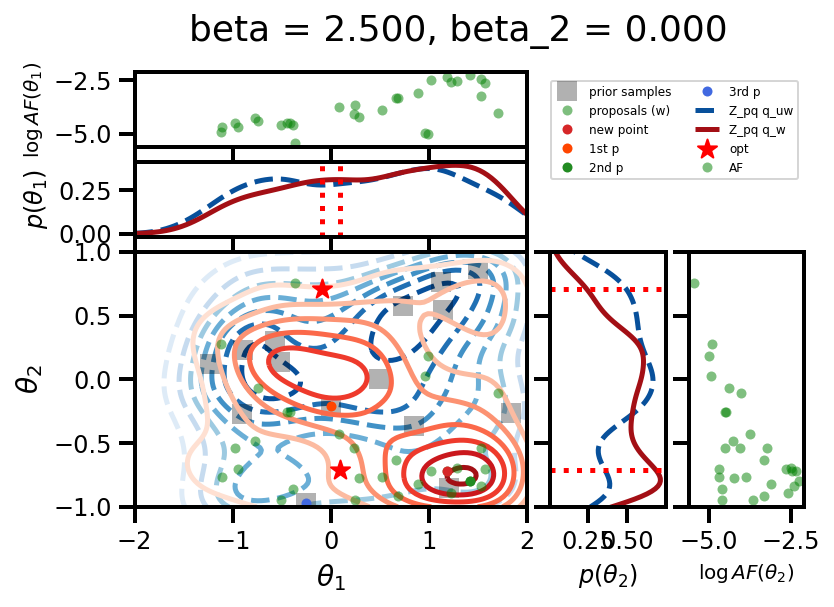

[[ 0.00871134 -0.02831459]
 [ 1.545377   -0.6412908 ]]


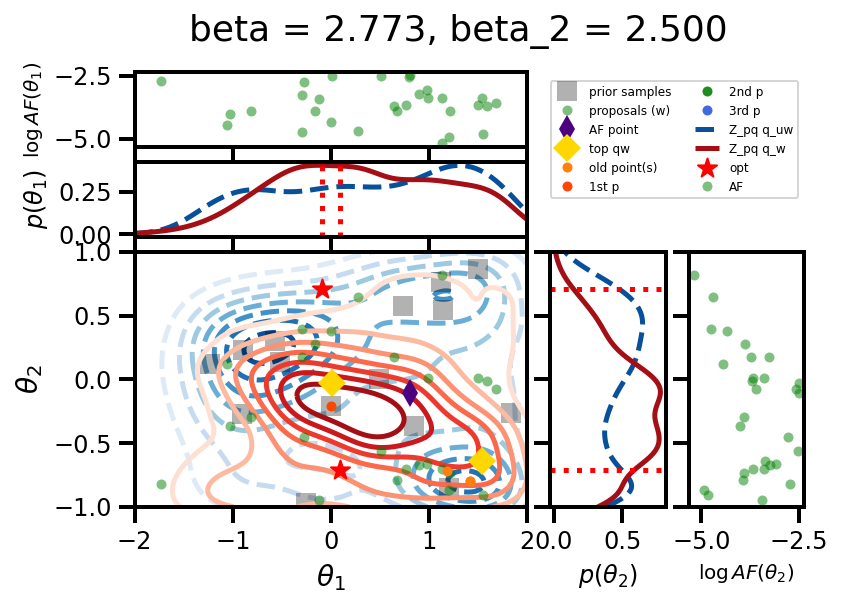

[[ 1.4155803  -0.90344507]
 [ 1.3842509  -0.80453074]]


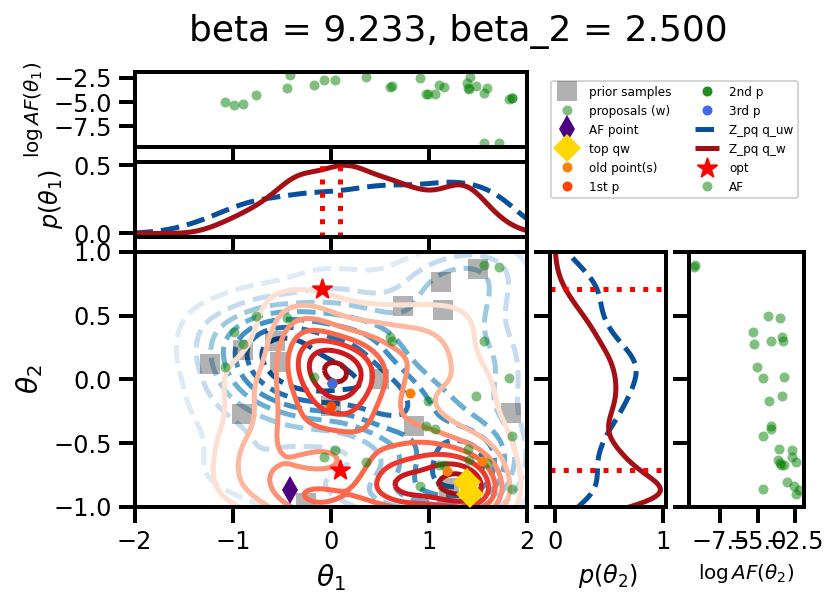

[[ 0.06014299 -0.04210567]
 [-0.21140492 -0.07965267]]


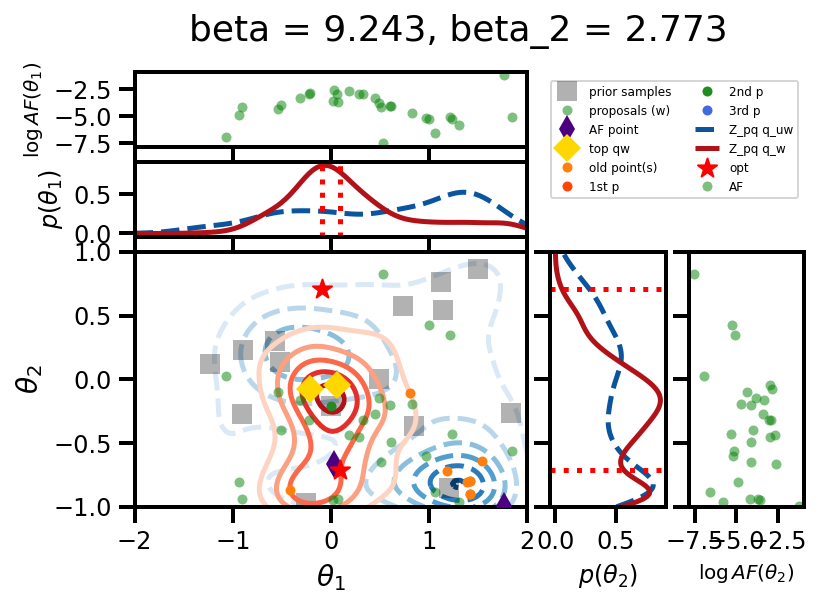

[[ 0.14526772 -0.61918676]
 [-0.28954852 -0.82590985]]


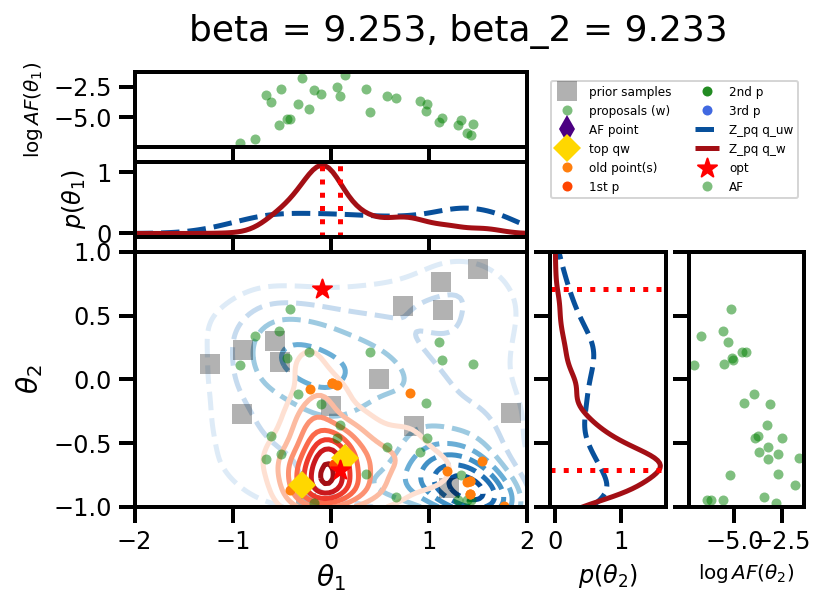

[[-0.05094194 -0.8124008 ]
 [ 0.09145641 -0.748926  ]]


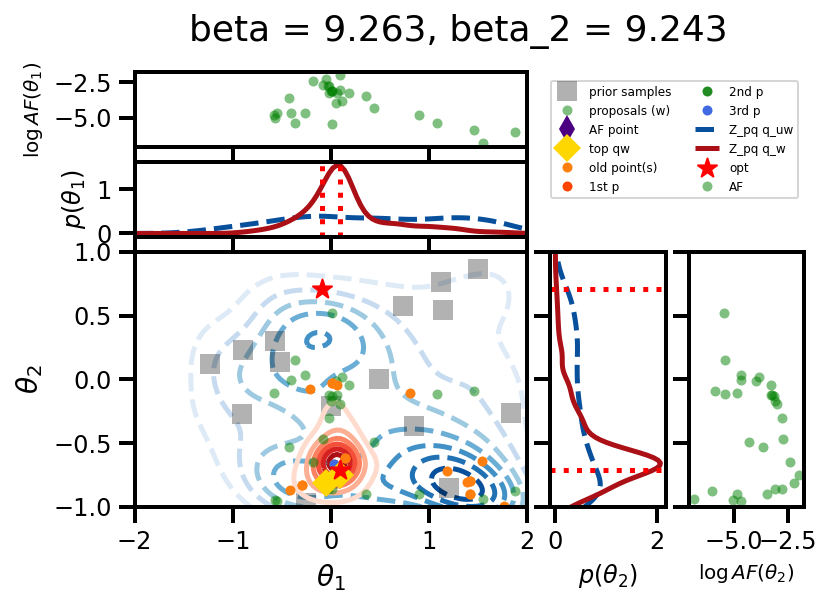

[[ 0.10574102 -0.6439334 ]
 [-0.02244091 -0.85811913]]


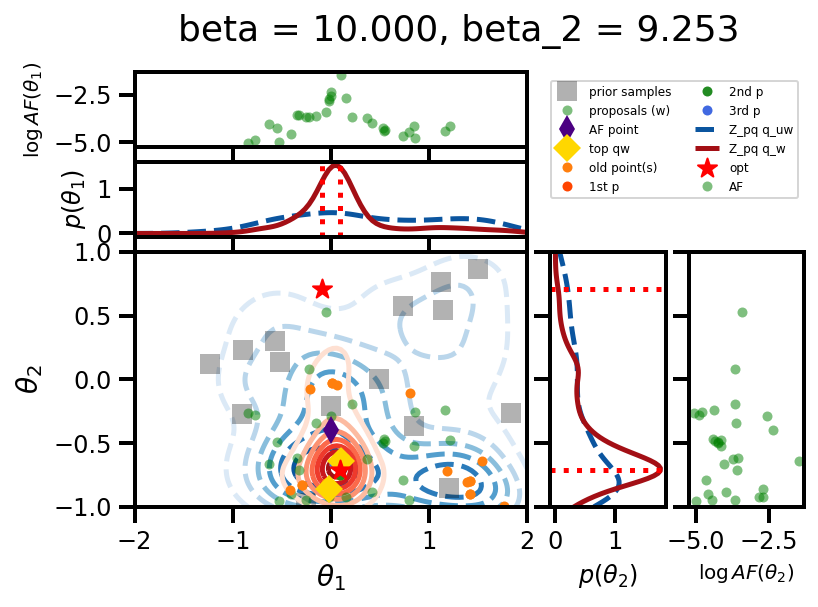

In [34]:
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
idx=2
for i in range(1,len(n0y[idx]['betas'][0])):
    single_beta_2d_plot(n0y[idx],
                        opts=np.array([[0.0898,-0.7126],[-0.0898,0.7126]]),
                        beta_idx=i,savename=savestr,
                       latent_sigma=True,low1=-2,high1=2,low2=-1,high2=1,
                        beta_max=10,n0=n0s[idx],bN=2,
                       dN=0,cN=2)
    